# Statistical Methods


In [1]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

## Data Set
Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A. Period of Record: March 1958 - December 2001

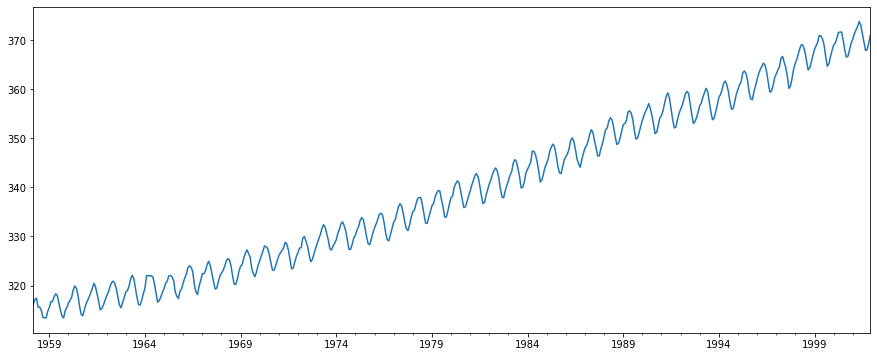

In [2]:
data = sm.datasets.co2.load_pandas()
y = data.data
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())
train = y[:'1997-12-01']
test = y['1998-01-01':]
y.plot(figsize=(15,6))
plt.show()

## ARIMA(p, d, q): (Autoregressive Integrated Moving Average)

In [3]:
arima_model = ARIMA(train, order=(1, 1, 1)).fit(disp=0)

arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.co2   No. Observations:                  477
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -747.585
Method:                       css-mle   S.D. of innovations              1.159
Date:                Mon, 31 Oct 2022   AIC                           1503.170
Time:                        21:30:12   BIC                           1519.840
Sample:                    04-01-1958   HQIC                          1509.725
                         - 12-01-1997                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1046      0.009     11.367      0.000       0.087       0.123
ar.L1.D.co2     0.8643      0.027     31.780      0.000       0.811       0.918
ma.L1.D.co2    -0.9786      0.009   -104.770      0.000      -0.997      -0.960
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1571           +0.0000j            1.1571            0.0000
MA.1            1.0218           +0.0000j            1.0218            0.0000
-----------------------------------------------------------------------------
"""

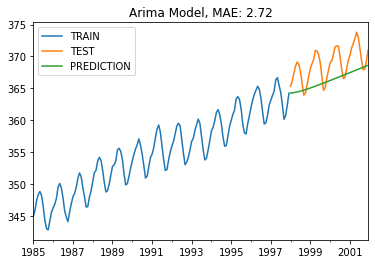

In [4]:
y_pred=arima_model.forecast(48)[0]
y_pred=pd.Series(y_pred,index=test.index)
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()
plot_co2(train,test,y_pred,"Arima Model")


### Hyperparameter Optimization (Model Derecelerini Belirleme)

In [5]:
# AIC & BIC İstatistiklerine Göre Model Derecesini Belirleme
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))


def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order).fit(disp=0)
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

best_params_aic = arima_optimizer_aic(train, pdq)

ARIMA(0, 0, 0) AIC=3954.01
ARIMA(0, 0, 1) AIC=3312.73
ARIMA(0, 1, 0) AIC=1522.49
ARIMA(0, 1, 1) AIC=1254.44
ARIMA(0, 1, 2) AIC=1138.37
ARIMA(0, 1, 3) AIC=1095.43
ARIMA(0, 2, 0) AIC=1281.81
ARIMA(0, 2, 1) AIC=1259.89
ARIMA(0, 2, 2) AIC=1249.75
ARIMA(0, 2, 3) AIC=1143.43
ARIMA(1, 0, 0) AIC=1536.59
ARIMA(1, 0, 1) AIC=1267.22
ARIMA(1, 0, 2) AIC=1149.97
ARIMA(1, 0, 3) AIC=1105.72
ARIMA(1, 1, 0) AIC=1209.00
ARIMA(1, 1, 1) AIC=1503.17
ARIMA(1, 2, 0) AIC=1258.05
ARIMA(2, 0, 0) AIC=1217.86
ARIMA(2, 0, 1) AIC=1168.37
ARIMA(2, 0, 2) AIC=1266.94
ARIMA(2, 1, 0) AIC=1103.80
ARIMA(2, 1, 2) AIC=855.34
ARIMA(2, 1, 3) AIC=800.75
ARIMA(2, 2, 0) AIC=1259.14
ARIMA(3, 0, 0) AIC=1115.61
ARIMA(3, 1, 0) AIC=1048.84
ARIMA(3, 2, 0) AIC=1211.68
Best ARIMA(2, 1, 3) AIC=800.75


### Final Model

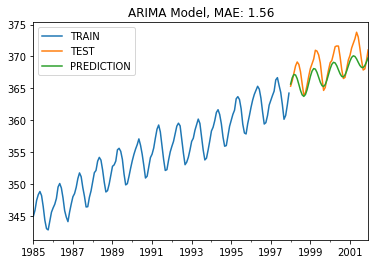

In [6]:
final_arima_model=ARIMA(train,best_params_aic).fit(disp=0)
y_pred=final_arima_model.forecast(48)[0]
y_pred=pd.Series(y_pred,index=test.index)
plot_co2(train,test,y_pred,"ARIMA Model")

## SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)

In [7]:
model=SARIMAX(train,order=(1,0,1),seasonal_order=(1,1,1,12))
sarima_model=model.fit(disp=0)

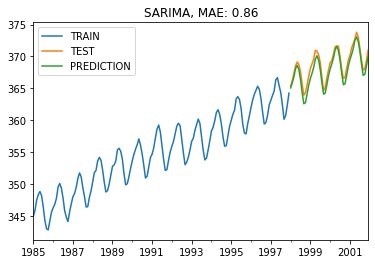

In [8]:
y_pred_test = sarima_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)
plot_co2(train, test, y_pred, "SARIMA")

### Hyperparameter Optimization

In [9]:
p=d=q=range(0,2)
pdq=list(itertools.product(p,d,q))
seasonable_pdq=[(x[0],x[1],x[2],12) for x in pdq]

In [10]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [11]:
pdq,seasonable_pdq=sarima_optimizer_aic(train,pdq,seasonable_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6922.606550808509
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6318.305219680289
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1643.999665788036
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1428.293892535883
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1851.4767832278812
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1611.293809038679
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1205.0254009699183
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:973.2077277130242
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6269.190364754439
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5663.56792852892
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1229.844751553384
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1126.5843176965404
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1503.8518511653133
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2032.8947515190841
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1008.1602684968211
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:767.6332918673911
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1523.9134546907108
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1154

### Final Model

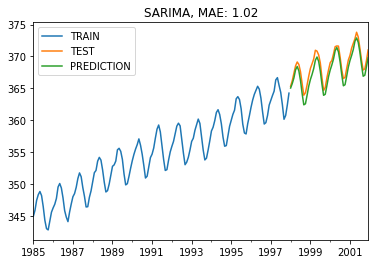

In [17]:
model = SARIMAX(train, order=pdq, seasonal_order=seasonable_pdq)
sarima_final_model = model.fit(disp=0)

y_pred_test = sarima_final_model.get_forecast(steps=48)

y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

### Hyperparameter Optimization (According to MAE)

In [21]:
p=d=q=range(0,2)
pdq=list(itertools.product(p,d,q))
seasonal_pdq=[(x[0],x[1],x[2],12) for x in pdq]

In [19]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=48)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order


SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:368.7634375
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:324.17909156740285
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:5.063020833333329
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:4.803324369766357
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:5.1065509631510055
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:4.829458826348706
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:3.323725253838147
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:1.5279746120906463
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:364.91786914276327
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:320.4050599411377
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:4.985339485404399
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:4.7653062077952955
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:4.997090514461593
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:5.029460758758755
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:3.6741583542972442
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:1.5668070380669878
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:4.526979166666667
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:3.9315401

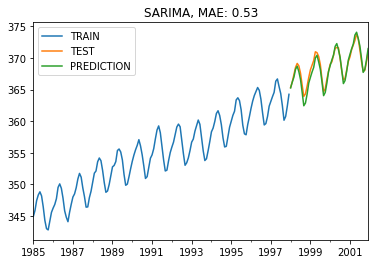

In [22]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

## Final Model

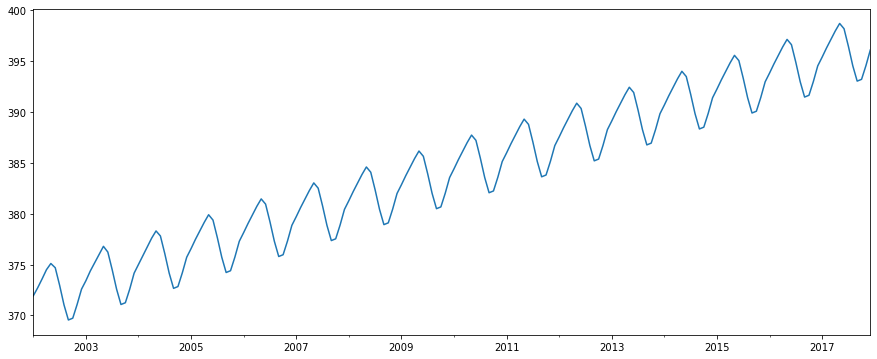

In [27]:
model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

feature_predict = sarima_final_model.get_forecast(steps=192)
feature_predict = feature_predict.predicted_mean
feature_predict.plot(figsize=(15,6))
plt.show()
